# Active Inference cadCAD model

This notebook explores active inference agent modeling in arbitrarily large grid worlds.

## Developing Active Inference Agents in cadCAD

An active inference agent consists of the following matrices:
- $A$ -> $P(o|s)$ the generative model's prior beliefs about how hidden states relate to observations
- $B$ -> $𝑃(𝑠_𝑡∣𝑠_{𝑡−1},𝑢_{𝑡−1})$ the generative model's prior beliefs about controllable transitions between hidden states over time
- $C$ -> $P(o)$ the biased generative model's prior preference for particular observations encoded in terms of probabilities
- $D$ -> $P(s)$ the generative model's prior belief over hidden states at the first timestep
- $E$ -> agent's affordances (in this notebook referred to as 'actions')

## cadCAD Standard Notebook Layout

### 0. Dependencies

In [1]:
import pandas as pd
import numpy as np
from random import normalvariate, random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from radcad import Model, Simulation, Experiment

from model import ActiveGridference
# Additional dependencies

# For analytics
import itertools

# For visualization
import plotly.express as px

# local utils
import utils as u
from control import construct_policies

### 0. Useful functions

In [2]:
grid = list(itertools.product(range(10), repeat=2))
print(grid)
act = ActiveGridference(grid)
act.get_C((9, 3))
act.get_D((0, 0))
print(act.border)
print(len(grid))

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
9.0
100


In [3]:
from pymdp.maths import softmax

print(softmax(act.A))

[[0.02672363 0.00983107 0.00983107 ... 0.00983107 0.00983107 0.00983107]
 [0.00983107 0.02672363 0.00983107 ... 0.00983107 0.00983107 0.00983107]
 [0.00983107 0.00983107 0.02672363 ... 0.00983107 0.00983107 0.00983107]
 ...
 [0.00983107 0.00983107 0.00983107 ... 0.02672363 0.00983107 0.00983107]
 [0.00983107 0.00983107 0.00983107 ... 0.00983107 0.02672363 0.00983107]
 [0.00983107 0.00983107 0.00983107 ... 0.00983107 0.00983107 0.02672363]]


### 1. State Variables

In [4]:
initial_state = {
    'prior_A': softmax(act.A),
    'prior_B': act.B,
    'prior_C': act.C,
    'prior': softmax(act.D),
    'env_state': grid[0],
    'action': '',
    'current_inference': ''
}

### 2. System Parameters

In [5]:
params = {
    'prior_A': softmax(act.A),
    'prior_B': act.B,
    'prior_C': act.C,
    'prior': softmax(act.D),
    'env_state': grid,
    'actions': act.E
}

### 3. Policy Functions

- `get_observation`
- `infer_states`
- `calc_efe`
- `calc_action_posterior`
- `sample_action`
- `calc_next_prior`
- `update_env_state`

In [6]:
def p_actinf(params, substep, state_history, previous_state):
    policies = construct_policies([act.n_states], [len(act.E)], policy_len = act.policy_len)
    # get obs_idx
    obs_idx = grid.index(previous_state['env_state'])

    # infer_states
    qs_current = u.infer_states(obs_idx, previous_state['prior_A'], previous_state['prior'])

    # calc efe
    G = u.calculate_G_policies(previous_state['prior_A'], previous_state['prior_B'], previous_state['prior_C'], qs_current, policies=policies)

    # calc action posterior
    Q_pi = u.softmax(-G)

    # compute the probability of each action
    P_u = u.compute_prob_actions(act.E, policies, Q_pi)

    # sample action
    chosen_action = u.sample(P_u)

    # calc next prior
    prior = previous_state['prior_B'][:,:,chosen_action].dot(qs_current) 

    # update env state
    # action_label = params['actions'][chosen_action]

    (Y, X) = previous_state['env_state']
    Y_new = Y
    X_new = X

    if chosen_action == 0: # UP
          
        Y_new = Y - 1 if Y > 0 else Y
        X_new = X

    elif chosen_action == 1: # DOWN

        Y_new = Y + 1 if Y < act.border else Y
        X_new = X

    elif chosen_action == 2: # LEFT
        Y_new = Y
        X_new = X - 1 if X > 0 else X

    elif chosen_action == 3: # RIGHT
        Y_new = Y
        X_new = X +1 if X < act.border else X

    elif chosen_action == 4: # STAY
        Y_new, X_new = Y, X 
        
    current_state = (Y_new, X_new) # store the new grid location

    return {'update_prior': prior,
            'update_env': current_state,
            'update_action': chosen_action,
            'update_inference': qs_current}

### 4. State Update Functions

In [7]:
def s_prior(params, substep, state_history, previous_state, policy_input):
    updated_prior = policy_input['update_prior']
    return 'prior', updated_prior

def s_env(params, substep, state_history, previous_state, policy_input):
    updated_env_state = policy_input['update_env']
    return 'env_state', updated_env_state

def s_action(params, substep, state_history, previous_state, policy_input):
    return 'action', policy_input['update_action']

def s_qs(params, substep, state_history, previous_state, policy_input):
    return 'current_inference', policy_input['update_inference']

### 5. Partial State Update Blocks

In [8]:
state_update_blocks = [
    {
        'policies': {
            'p_actinf': p_actinf
        },
        'variables': {
            'prior': s_prior,
            'env_state': s_env,
            'action': s_action,
            'current_inference': s_qs
        }
    }
]

### 6. Configuration

In [9]:
model = Model(
    # Model initial state
    initial_state=initial_state,
    # Model Partial State Update Blocks
    state_update_blocks=state_update_blocks,
    # System Parameters
    params=params
)

### 7. Execution

In [13]:
simulation = Simulation(
    model=model,
    timesteps=100,  # Number of timesteps
    runs=1  # Number of Monte Carlo Runs
)

In [14]:
result = simulation.run()

### 8. Analysis

In [15]:
df = pd.DataFrame(result)
df

,prior_A,prior_B,prior_C,prior,env_state,action,current_inference,simulation,subset,run,substep,timestep
0,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02672363098939523, 0.009831074434450556, 0....","(0, 0)",,,0,0,1,0,0
1,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1, 0)",1,"[0.0694531596563796, 0.00939946303377394, 0.00...",0,0,1,1,1
2,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2, 0)",1,"[8.933835195079347e-17, 8.933835195079347e-17,...",0,0,1,1,2
3,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.2432570305759068e-16, 2.2432570305759068e-1...","(1, 0)",0,"[7.753058021694265e-17, 7.753058021694265e-17,...",0,0,1,1,3
4,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2, 0)",1,"[2.0134671970778882e-16, 2.0134671970778882e-1...",0,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
10095,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 5.032147244080602e-17, 5.032147244080602...","(8, 2)",3,"[5.032147244080602e-17, 5.032147244080602e-17,...",0,99,1,1,96
10096,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.208812339473694e-17, 5.53001792775925e-17, ...","(8, 1)",2,"[3.678794411714443e-17, 5.53001792775925e-17, ...",0,99,1,1,97
10097,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.066527149012729e-17, 5.71317431664662e-17, ...","(8, 1)",4,"[7.066527149012729e-17, 5.71317431664662e-17, ...",0,99,1,1,98
10098,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(9, 1)",1,"[6.278424470316125e-17, 5.780553786637451e-17,...",0,99,1,1,99


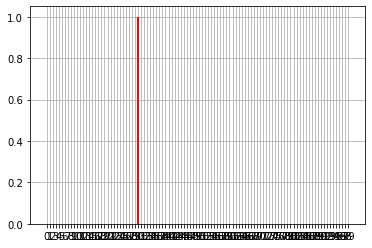

In [36]:
u.plot_beliefs(df['prior'][99])